# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [1]:
from dvats.all import *
from fastcore.all import *
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!
from fastai.callback.wandb import WandbCallback
import wandb
wandb_api = wandb.Api()

In [2]:
config = AttrDict(
    alias = None, # Alias of the artifact resulting of this run. None will create one automatically
    wandb_group = None, # Whether to group this run in a wandb group
    wandb_entity = os.environ['WANDB_ENTITY'], # The entity to use for the wandb group
    wandb_project = os.environ['WANDB_PROJECT'], # The project to use for the wandb group
    train_artifact = 'deepvats/deepvats/gtrends_kohl:v0', # entity/project/name:version
    valid_artifact = None, # entity/project/name:version
    valid_size = 0.1, # In case valid_artifact is None, this will set the percentage of random items to go to val
    w = 20, # window size for the sliding window (taxi=48, steamflow=640)
    mvp_ws = None, # Tuple (min_w, max_x) to train MVP with adaptable window sizes. Usually max_w = config.w
    norm_by_sample = False, # Normalize by sample or not
    norm_use_single_batch = False, # Whether to use a single batch or not for the normalization (TSStandardize)
    r = 0.3, # probability of masking in MVP
    stride = 1, # n datapoints the window is moved ahead along the sequence in the sliding window
    batch_size = 32,
    epochs = 250,
    use_wandb = True, # Whether to use or not wandb for experiment trackin
)

In [3]:
#hide
run = wandb.init(entity = config.wandb_entity,
                      # work-nbs is a place to log draft runs
                      project=config.wandb_project if config.use_wandb else 'work-nbs',
                      group=config.wandb_group,
                      job_type='encoder_MVP',
                      allow_val_change=True,
                      mode='online' if config.use_wandb else 'disabled', # Need to be always online to download artifacts
                      config=config,
                      # When use_wandb is false the run is not linked to a personal account
                      #NOTE: This is not working right now
                      anonymous = 'never' if config.use_wandb else 'must',
                      resume=False)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vrodriguezf90 (use `wandb login --relogin` to force relogin)


In [4]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [5]:
train_artifact = artifacts_gettr(config.train_artifact)
df_train = train_artifact.to_df()
X_train, _ = sw(df_train)
df_train.shape, X_train.shape

((550, 1), (531, 1, 20))

In [6]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape

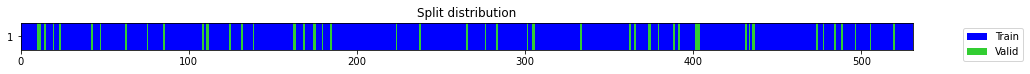

((#478) [441,449,308,428,233,60,21,55,359,5...],
 (#53) [237,23,496,477,519,124,435,85,138,111...])

In [7]:
if config.valid_artifact:
    X, _, splits  = combine_split_data(xs=[X_train, X_valid])
else:
    X = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits

Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

In [8]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

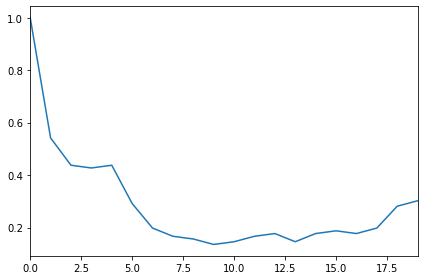

WandbCallback requires use of "SaveModelCallback" to log best model


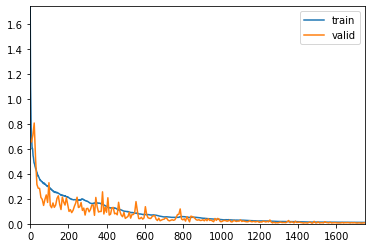


epochs: 250 best epoch: 246  val_loss: 0.005522 - pretrained weights_path='models/encoder_MVP.pth'



[1.180008888244629]
not enough values to plot a chart


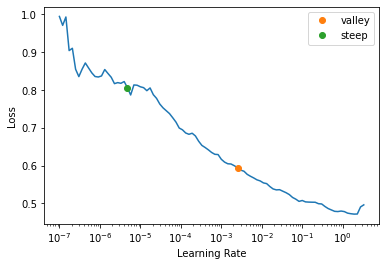

In [51]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]
dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.show_at(0)
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + ShowGraphCallback() + MVP(r = config.r, 
                   window_size=config.mvp_ws, future_mask = True, target_dir='./models', 
                   fname=f'encoder_MVP'), y_range=[X.min(), X.max()])
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
with learn.no_mbar() and learn.no_logging():
     learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley)
print(learn.validate())
learn.plot_metrics()

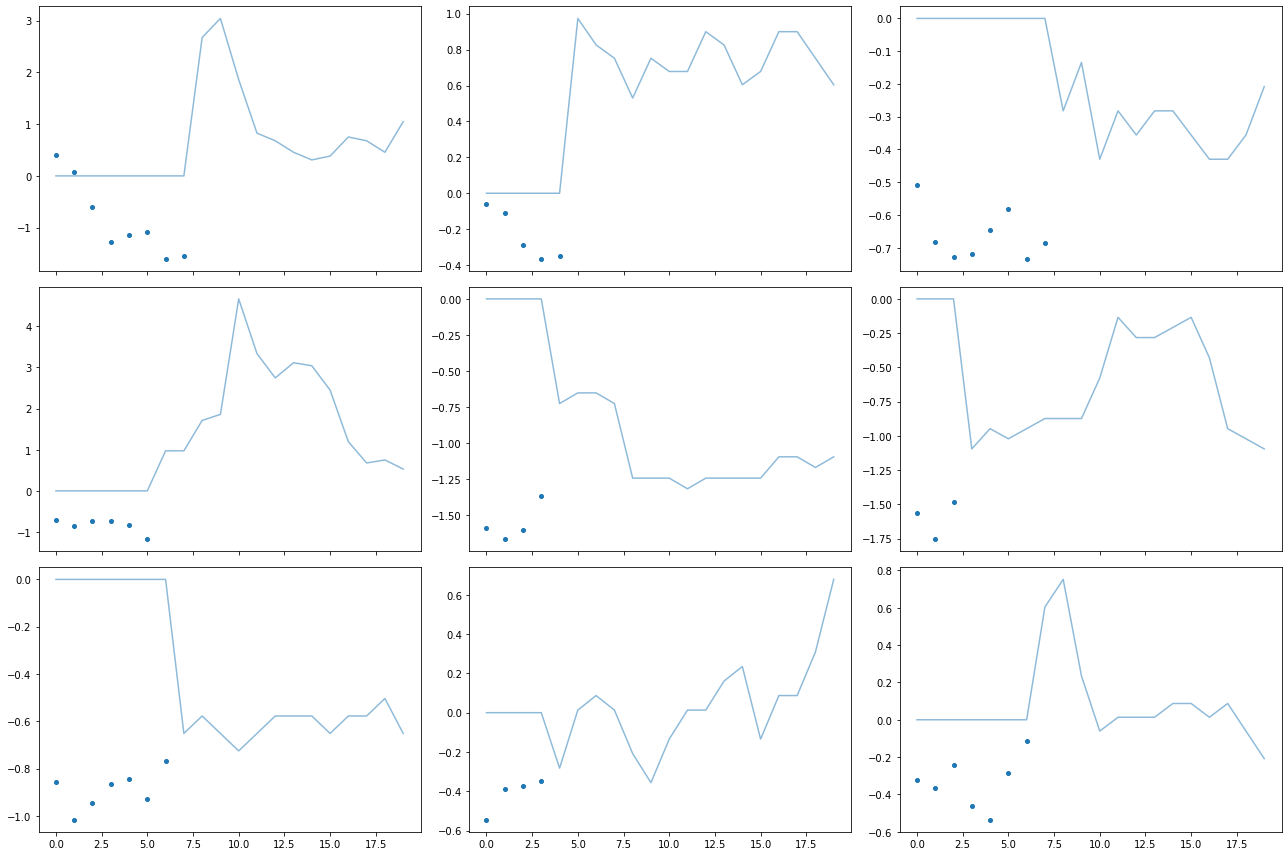

In [52]:
learn.MVP.show_preds()

In [53]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: run.log_artifact(ReferenceArtifact(aux_learn, f'mvp', type='learner', metadata=dict(run.config)), 
                                      aliases=config.alias)

In [54]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▆▆▄▅▅▅▃▂▃▃▂▂▃▁▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
